# Wind Rose Plot

This notebook fetches wind rose data from the Iowa Environmental Mesonet and creates a wind rose visualization showing the distribution of wind speed and direction.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import io
from matplotlib.patches import Circle

%matplotlib inline
plt.style.use('default')

In [218]:
# Configuration: Set the month to analyze (1-12, where 1=January, 12=December)
# Set to None to get data for all months
month = 1 # Change this value to analyze different months

# Build URL for wind rose data
base_url = "https://mesonet.agron.iastate.edu/cgi-bin/mywindrose.py"

# URL Parameters Explanation:
# --------------------------
# nsector: Number of directional sectors (bins) - 36 means 360°/36 = 10° per sector
# station: Weather station code (CWA = Central Wisconsin Airport/Mosinee)
# network: Network identifier (WI_ASOS = Wisconsin Automated Surface Observing System)
# 
# Date/Time Range Parameters:
# year1, month1, day1: Start date (year1=1970, month1=1=January, day1=1)
# year2, month2, day2: End date (year2=2026, month2=1=January, day2=1)
# hour1, minute1: Start time (hour1=0=midnight, minute1=0)
# hour2, minute2: End time (hour2=0=midnight, minute2=0)
# 
# Note: The date range spans from year1/month1/day1 to year2/month2/day2
# If monthlimit=1 is added, only the month specified in month1 is used
# 
# Other Parameters:
# units: Wind speed units - 'mph' (miles per hour) or 'mps' (meters per second)
# justdata: 'true' = return only CSV data, 'false' = return HTML page

params = {
    'nsector': 36,              # 36 sectors = 10° per sector
    'station': 'CWA',           # Station: Central Wisconsin Airport
    'network': 'WI_ASOS',       # Network: Wisconsin ASOS
    'year1': 1970,              # Start year
    'month1': 1,                # Start month (1=Jan, 12=Dec) - will be overridden if month variable is set
    'day1': 1,                  # Start day
    'year2': 2026,              # End year
    'month2': 1,                # End month (1=Jan, 12=Dec)
    'day2': 1,                  # End day
    'hour1': 0,                 # Start hour (0-23, 0=midnight)
    'hour2': 0,                 # End hour (0-23, 0=midnight)
    'minute1': 0,               # Start minute (0-59)
    'minute2': 0,               # End minute (0-59)
    'units': 'mph',             # Wind speed units: 'mph' or 'mps'
    'justdata': 'true'          # Return only data (not HTML page)
}

# Add month-specific parameters if a specific month is selected
if month is not None:
    params['month1'] = month
    params['monthlimit'] = 1

# Construct URL
url = base_url + '?' + '&'.join([f'{k}={v}' for k, v in params.items()])

print(f"Fetching wind rose data for month: {month if month else 'All months'}")
print(f"URL: {url}\n")

# Fetch data
with urllib.request.urlopen(url) as response:
    data = response.read().decode('utf-8')

print("Data fetched successfully!")
print(f"First 500 characters:\n{data[:500]}")

Fetching wind rose data for month: 1
URL: https://mesonet.agron.iastate.edu/cgi-bin/mywindrose.py?nsector=36&station=CWA&network=WI_ASOS&year1=1970&month1=1&day1=1&year2=2026&month2=1&day2=1&hour1=0&hour2=0&minute1=0&minute2=0&units=mph&justdata=true&monthlimit=1

Data fetched successfully!
First 500 characters:
# Windrose Data Table (Percent Frequency) for MOSINEE/CENTRAL (CWA)
# Observations Used/Missing/Total: 18845/0/18845
# 01 Jan 1973 06:00 AM - 31 Jan 2025 11:55 PM America/Chicago
#   constraints: Jan
# Wind Speed Units: miles per hour
# Generated 04 Nov 2025 20:05 UTC, contact: akrherz@iastate.edu
# First value in table is CALM
Direction,Calm     , 2.0  4.9, 5.0  6.9, 7.0  9.9,10.0 14.9,15.0 19.9,20.0+    
355-004  ,13.68    ,    0.371,    0.642,    0.409,    0.557,    0.202,    0.064
005-014  ,


In [219]:
# Parse the data
lines = data.strip().split('\n')

# Extract metadata
metadata = {}
data_start_idx = 0
for i, line in enumerate(lines):
    if line.startswith('#'):
        if 'Windrose Data Table' in line:
            # Extract station info
            if 'MOSINEE' in line:
                metadata['station'] = 'MOSINEE/CENTRAL (CWA)'
        elif 'Observations Used' in line:
            # Extract observation counts
            parts = line.split(':')
            if len(parts) > 1:
                metadata['observations'] = parts[1].strip()
        elif 'Obs Between:' in line or ('Dec' in line and 'PM' in line):
            # Extract date range
            metadata['date_range'] = line.replace('#', '').strip()
        elif 'Wind Speed Units' in line:
            metadata['units'] = line.split(':')[1].strip() if ':' in line else 'mph'
    else:
        if 'Direction' in line:
            # This is the header line
            data_start_idx = i + 1
            header = line.split(',')
            break

print("Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Metadata:
  station: MOSINEE/CENTRAL (CWA)
  observations: 18845/0/18845
  units: miles per hour


In [220]:
# Parse the data table
data_lines = [line for line in lines[data_start_idx:] if line.strip() and not line.startswith('#')]

# Parse CSV-like data
wind_data = []
calm_value = None

for line in data_lines:
    parts = [p.strip() for p in line.split(',')]
    if len(parts) >= 2:
        direction = parts[0]
        values = [float(v) if v else 0.0 for v in parts[1:]]
        
        # First row contains calm value
        if '355-004' in direction or calm_value is None:
            calm_value = values[0] if len(values) > 0 else 0.0
            values = values[1:]  # Remove calm from speed categories
        
        wind_data.append({
            'direction': direction,
            'calm': calm_value if '355-004' in direction else 0.0,
            '2.0-4.9': values[0] if len(values) > 0 else 0.0,
            '5.0-6.9': values[1] if len(values) > 1 else 0.0,
            '7.0-9.9': values[2] if len(values) > 2 else 0.0,
            '10.0-14.9': values[3] if len(values) > 3 else 0.0,
            '15.0-19.9': values[4] if len(values) > 4 else 0.0,
            '20.0+': values[5] if len(values) > 5 else 0.0
        })
        calm_value = 0.0  # Only first row has calm

df = pd.DataFrame(wind_data)
print(f"Parsed {len(df)} direction sectors")
print("\nFirst few rows:")
print(df.head())

Parsed 36 direction sectors

First few rows:
  direction   calm  2.0-4.9  5.0-6.9  7.0-9.9  10.0-14.9  15.0-19.9  20.0+
0   355-004  13.68    0.371    0.642    0.409      0.557      0.202  0.064
1   005-014   0.00    0.000    0.334    0.456      0.377      0.292  0.080
2   015-024   0.00    0.000    0.228    0.398      0.223      0.366  0.048
3   025-034   0.00    0.000    0.218    0.350      0.223      0.239  0.048
4   035-044   0.00    0.000    0.180    0.287      0.212      0.233  0.069


In [221]:
# Convert direction ranges to center angles (in radians for polar plot)
def direction_to_angle(direction_str):
    """Convert direction range (e.g., '355-004') to center angle in radians"""
    parts = direction_str.split('-')
    if len(parts) == 2:
        start = int(parts[0])
        end = int(parts[1])
        # Handle wrap-around (e.g., 355-004)
        if end < start:
            center_deg = (start + (end + 360)) / 2
        else:
            center_deg = (start + end) / 2
        # Convert to matplotlib polar coordinates
        # With theta_zero_location('N') and theta_direction(-1):
        # - 0 radians is at North (top)
        # - Positive angles go clockwise
        # Meteorological: 0°=N, 90°=E, 180°=S, 270°=W (clockwise)
        # So we use center_deg directly (no negation needed)
        angle_rad = np.deg2rad(center_deg)
        return angle_rad
    return 0

df['angle'] = df['direction'].apply(direction_to_angle)
df['angle_deg'] = df['direction'].apply(lambda x: (int(x.split('-')[0]) + (int(x.split('-')[1]) + 360 if int(x.split('-')[1]) < int(x.split('-')[0]) else int(x.split('-')[1]))) / 2)

print("\nDirection angles calculated:")
print(df[['direction', 'angle_deg']].head(10))


Direction angles calculated:
  direction  angle_deg
0   355-004      359.5
1   005-014        9.5
2   015-024       19.5
3   025-034       29.5
4   035-044       39.5
5   045-054       49.5
6   055-064       59.5
7   065-074       69.5
8   075-084       79.5
9   085-094       89.5


In [222]:
# Save the wind rose data to CSV
csv_filename = 'wind_rose_data.csv'
df.to_csv(csv_filename, index=False)
print(f"Wind rose data saved to '{csv_filename}'")
print(f"Total rows: {len(df)}")
print(f"Columns: {', '.join(df.columns.tolist())}")


Wind rose data saved to 'wind_rose_data.csv'
Total rows: 36
Columns: direction, calm, 2.0-4.9, 5.0-6.9, 7.0-9.9, 10.0-14.9, 15.0-19.9, 20.0+, angle, angle_deg


In [223]:
# Calculate sector width (in radians)
# 36 sectors = 360/36 = 10 degrees per sector
sector_width = np.deg2rad(360 / 36)  # 10 degrees in radians

# Speed categories in order (from center outward)
speed_categories = ['2.0-4.9', '5.0-6.9', '7.0-9.9', '10.0-14.9', '15.0-19.9', '20.0+']

# Color scheme matching the reference image
# Blue, Cyan, Light Green, Yellow, Orange, Dark Red/Brown
colors = ['#0066CC', '#00CCFF', '#66FF99', '#FFFF00', '#FF9900', '#CC0000']

# Calculate calm percentage (from first row)
calm_percentage = df[df['direction'].str.contains('355-004', na=False)]['calm'].values[0] if len(df[df['direction'].str.contains('355-004', na=False)]) > 0 else 0.0

print(f"Calm percentage: {calm_percentage:.2f}%")
print(f"Sector width: {np.rad2deg(sector_width):.1f} degrees")

Calm percentage: 13.68%
Sector width: 10.0 degrees


Maximum frequency in data: 6.28%
Maximum radius set to: 7.0%


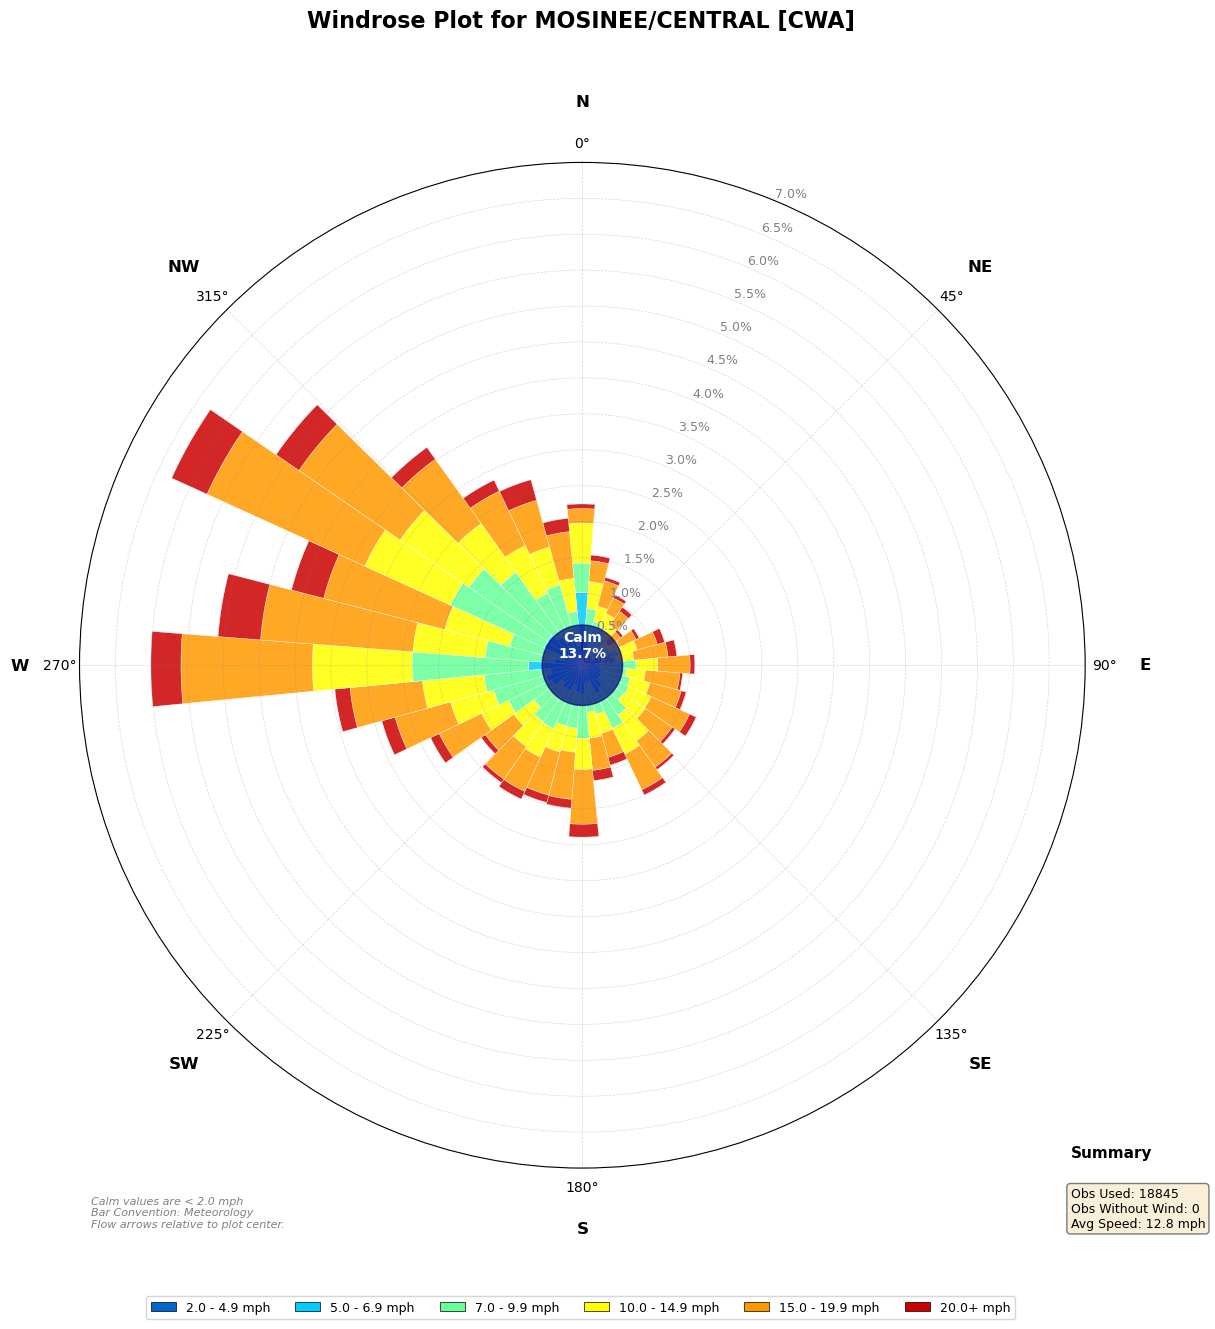

Wind rose plot saved as 'wind_rose_plot.png'


In [224]:
# Create the wind rose plot
fig = plt.figure(figsize=(14, 14))

# Main polar plot
ax = fig.add_subplot(111, projection='polar')

# Set up the polar plot
ax.set_theta_zero_location('N')  # 0 degrees at top (North)
ax.set_theta_direction(-1)  # Clockwise (meteorological convention)

# Calculate maximum radius dynamically based on data
# Find the maximum total frequency (sum of all speed categories) for any direction
max_freq = df[speed_categories].sum(axis=1).max()
# Add small margin (10%) and round up to next 0.5 for nice tick marks
max_radius = np.ceil(max_freq * 1.1 * 2) / 2  # Round up to nearest 0.5
# Ensure minimum of 2.0% for visibility
max_radius = max(2.0, max_radius)
# Cap at a reasonable maximum (e.g., 10.0%) to avoid extremely large scales
max_radius = min(max_radius, 10.0)

ax.set_ylim(0, max_radius)

print(f"Maximum frequency in data: {max_freq:.2f}%")
print(f"Maximum radius set to: {max_radius:.1f}%")

# Draw concentric circles for reference (in 0.5% increments)
radial_ticks = np.arange(0, max_radius + 0.5, 0.5)
ax.set_yticks(radial_ticks)
ax.set_yticklabels([f'{tick:.1f}%' if tick > 0 else '0.0%' for tick in radial_ticks], 
                   fontsize=9, color='gray')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='gray')

# Plot each direction sector with stacked wedges
for idx, row in df.iterrows():
    angle = row['angle']
    bottom_radius = 0
    
    # Draw stacked wedges for each speed category (from center outward)
    for i, category in enumerate(speed_categories):
        value = row[category]
        if value > 0:
            # Create theta array for the wedge (arc spanning the sector width)
            theta_start = angle - sector_width / 2
            theta_end = angle + sector_width / 2
            theta = np.linspace(theta_start, theta_end, 50)
            
            # Create radius array: inner radius (bottom_radius) to outer radius (bottom_radius + value)
            r_inner = bottom_radius
            r_outer = bottom_radius + value
            
            # Create closed polygon for the wedge
            theta_poly = np.concatenate([theta, theta[::-1]])
            r_poly = np.concatenate([np.full_like(theta, r_outer), np.full_like(theta, r_inner)])
            
            # Fill the wedge
            ax.fill(theta_poly, r_poly, color=colors[i], edgecolor='white', linewidth=0.3, alpha=0.85)
            bottom_radius += value

# Add calm circle at center
if calm_percentage > 0:
    calm_radius = max_radius * 0.08
    theta_center = np.linspace(0, 2*np.pi, 100)
    r_calm = np.full_like(theta_center, calm_radius)
    ax.fill(theta_center, r_calm, color='#000080', alpha=0.7, zorder=10)
    # Add calm label
    ax.text(0, calm_radius * 0.5, f'Calm\n{calm_percentage:.1f}%', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            color='white', zorder=11)

# Add directional labels
# With theta_zero_location('N') and theta_direction(-1), we use angle_deg directly
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
dir_angles_deg = [0, 45, 90, 135, 180, 225, 270, 315]
for direction, angle_deg in zip(directions, dir_angles_deg):
    # Use angle_deg directly (same as data conversion)
    angle_rad = np.deg2rad(angle_deg)
    label_radius = max_radius * 1.12
    ax.text(angle_rad, label_radius, direction, 
            ha='center', va='center', fontsize=12, fontweight='bold',
            color='black')

# Title
station_name = metadata.get('station', 'MOSINEE/CENTRAL (CWA)').replace('(CWA)', '[CWA]')
plt.suptitle(f'Windrose Plot for {station_name}', fontsize=16, fontweight='bold', y=0.97)

# Add date range and observations info
date_range = metadata.get('date_range', '')
if date_range:
    plt.figtext(0.5, 0.02, f'Obs Between: {date_range}', fontsize=10, ha='center')

# Add summary statistics
total_obs = metadata.get('observations', '').split('/')[2] if '/' in metadata.get('observations', '') else 'N/A'
obs_used = metadata.get('observations', '').split('/')[0] if '/' in metadata.get('observations', '') else 'N/A'

# Calculate average speed (approximate from percentages)
speed_midpoints = [3.45, 5.95, 8.45, 12.45, 17.45, 25.0]  # Midpoints of speed ranges
total_weighted_speed = 0
total_percentage = 0
for i, category in enumerate(speed_categories):
    category_total = df[category].sum()
    total_weighted_speed += category_total * speed_midpoints[i]
    total_percentage += category_total
avg_speed = total_weighted_speed / total_percentage if total_percentage > 0 else 0

# Add summary text box
summary_text = f'Obs Used: {obs_used}\nObs Without Wind: 0\nAvg Speed: {avg_speed:.1f} mph'
plt.figtext(0.85, 0.15, 'Summary', fontsize=11, fontweight='bold', ha='left')
plt.figtext(0.85, 0.10, summary_text, fontsize=9, ha='left', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add legend at bottom
legend_labels = ['2.0 - 4.9 mph', '5.0 - 6.9 mph', '7.0 - 9.9 mph', 
                '10.0 - 14.9 mph', '15.0 - 19.9 mph', '20.0+ mph']
legend_patches = [plt.Rectangle((0, 0), 1, 1, facecolor=color, 
                               edgecolor='black', linewidth=0.5) for color in colors]

# Place legend at bottom center
fig.legend(legend_patches, legend_labels, loc='lower center', 
          ncol=6, frameon=True, fontsize=9, bbox_to_anchor=(0.5, 0.03))

# Add notes
notes_text = 'Calm values are < 2.0 mph\nBar Convention: Meteorology\nFlow arrows relative to plot center.'
plt.figtext(0.15, 0.10, notes_text, fontsize=8, ha='left', 
            style='italic', color='gray')

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

# Save the figure
fig.savefig('wind_rose_plot.png', dpi=150, bbox_inches='tight')
print("Wind rose plot saved as 'wind_rose_plot.png'")